# Omniglot

The Omniglot data set was designed for developing human-like learning algorithms. It contains 1623 different handwritten characters from 50 different alphabets. Each of the 1623 characters was drawn online via Amazon's Mechanical Turk by 20 different people. It consists of background and evaluation datasets.

## few shot learning

Where, lots of deep learning projects are based on a large number of training examples, few-shot learning is based only on a few. This approach is much closer to the one experienced by humans. We are able to memorize and recognize objects we have never seen before from a few number of examples. Then for each new one we observe with these types of object we can then classify them in an accurate and easy way.

## Implementation

I am going to use a metric meta-learning approach. To learn, we need to extract the maximum information with the least amount of memory possible. This depends on how well we extract features and not over do it. we want to find features that make samples belong to the same class or different class. I am going to use a Siamese Neural Network model with binary cross entropy for training and testing the omniglot data set. then I am going to compare this model with a baseline (k nearest neighbors) and see whether the Siamese Neural Network model performed better than the baseline or not.

First we import the required Libraries

In [1]:
import sys
import numpy as np
import pandas as pd
from imageio import imread
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import gc

import tensorflow as tf
import keras as kr

from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

Using TensorFlow backend.


paths of the train and evaluation folders

In [2]:
train_folder = "images_background/"
val_folder = 'images_evaluation/'

We will write a function for loading the data sets

In [3]:
# Loads the train or test data sets
def load_data(path):
    '''
    path => Path of train directory or test directory
    '''
    Chars=[] # contains images for each letter of each alphabet in train or test set
    Alpha_dict = {} # a dictionary that will contain alphabets along with their start and (end+1) positions in trian or test
    curr_nl = 0 # current number of letters in train or test set 
    # we load every alphabet seperately so we can isolate them later
    for alpha in os.listdir(path):
        #print("loading alphabet: " + alphabet)
        Alpha_dict[alpha] = [curr_nl,curr_nl]
        alpha_path = os.path.join(path,alpha)
        # every letter or character has it's own column in the array, so  load seperately
        for char in os.listdir(alpha_path):
            char_images=[]
            char_path = os.path.join(alpha_path, char)
            # read all the images in the current character
            for filename in os.listdir(char_path):
                image_path = os.path.join(char_path, filename)
                image = imread(image_path)
                char_images.append(image)
            # stack the character images and append to the Chars array
            Chars.append(np.stack(char_images))

            curr_nl += 1
            Alpha_dict[alpha][1] = curr_nl
    
    Chars = np.stack(Chars)
    return  Chars,Alpha_dict

Loading the training data

In [4]:
train,alpha_train=load_data(train_folder)

Loading the test data

In [5]:
test,alpha_test=load_data(val_folder)

## Exploratory Data Analysis

In [6]:
print("train shape: ", train.shape)
print("test shape: ", test.shape)

train shape:  (964, 20, 105, 105)
test shape:  (659, 20, 105, 105)


From above it seems there are 964 characters in the training set where there are only 659 characters in the test set and each character has 20 examples.

In [7]:
print('Number of training alphabets: ', len(alpha_train.keys()))
print('Number of testing alphabets: ', len(alpha_test.keys()))

Number of training alphabets:  30
Number of testing alphabets:  20


Lets Analyise the number of characters in the training set

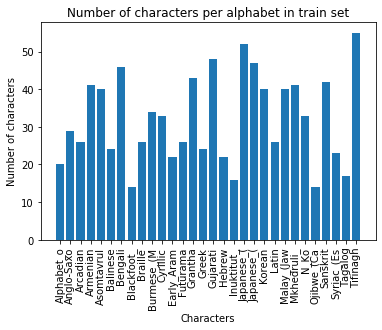

Train set summary:

The maximum number of characters for one alphabet is 55
The minimum number of characters for one alphabet is 14
The mean number of characters is 32.13
The median number of characters is 31.0
The total number of different character is 964


In [8]:
alpha_tr = alpha_train.keys()
num_of_char_per_alpha_tr = [(b - a) for (a,b) in alpha_train.values()]

plt.bar(range(30), num_of_char_per_alpha_tr)
plt.xlabel('Characters')
plt.ylabel('Number of characters')
plt.xticks(range(30), [alpha[:10] for alpha in alpha_tr], rotation=90)
plt.title('Number of characters per alphabet in train set')
plt.show()
print('Train set summary:')
print(f'\nThe maximum number of characters for one alphabet is {max(num_of_char_per_alpha_tr)}')
print(f'The minimum number of characters for one alphabet is {min(num_of_char_per_alpha_tr)}')
print(f'The mean number of characters is {np.round(np.mean(num_of_char_per_alpha_tr), 2)}') 
print(f'The median number of characters is {np.median(num_of_char_per_alpha_tr)}')
print(f'The total number of different character is {train.shape[0]}')

Lets look at an example of a character in the training set

character: Bengali, img shape: (105, 105)


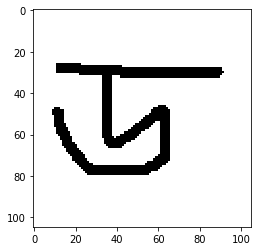

In [9]:
alpha = np.random.choice(list(alpha_train.keys()))
character = np.random.randint(alpha_train[alpha][0],alpha_train[alpha][1])
example = np.random.randint(train.shape[1])
image = train[character, example]
plt.imshow(np.asarray(image), cmap='gray')
print(f'character: {alpha}, img shape: {image.shape}')

Lets Analyise the number of characters in the test set

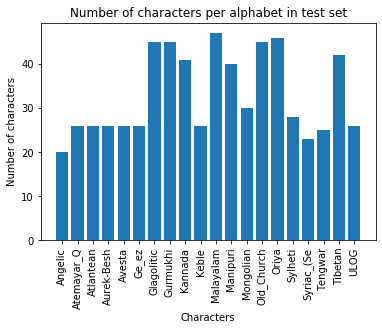

Test set summary:

The maximum number of characters for one alphabet is 47
The minimum number of characters for one alphabet is 20
mean number of characters is 32.95
median number of characters is 27.0
The total number of different character is 659


In [10]:
alpha_tt = alpha_test.keys()
num_of_char_per_alpha_tt = [(b - a) for (a,b) in alpha_test.values()]

plt.bar(range(20), num_of_char_per_alpha_tt)
plt.xlabel('Characters')
plt.ylabel('Number of characters')
plt.xticks(range(20), [alpha[:10] for alpha in alpha_tt], rotation=90)
plt.title('Number of characters per alphabet in test set')
plt.show()
print('Test set summary:')
print(f'\nThe maximum number of characters for one alphabet is {max(num_of_char_per_alpha_tt)}')
print(f'The minimum number of characters for one alphabet is {min(num_of_char_per_alpha_tt)}')
print(f'mean number of characters is {np.round(np.mean(num_of_char_per_alpha_tt), 2)}') 
print(f'median number of characters is {np.median(num_of_char_per_alpha_tt)}')
print(f'The total number of different character is {test.shape[0]}')

Lets look at an example of a character in the test set

character: ULOG, img shape: (105, 105)


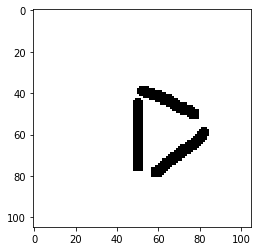

In [11]:
alpha = np.random.choice(list(alpha_test.keys()))
character = np.random.randint(alpha_test[alpha][0],alpha_test[alpha][1])
example = np.random.randint(test.shape[1])
image = test[character, example]
plt.imshow(np.asarray(image), cmap='gray')
print(f'character: {alpha}, img shape: {image.shape}')

## siamese network

Siamese network is a Deep Nueral Network architecture proposed by Gregory et. al in his paper Siamese Neural Networks for One-shot Image Recognition. The paper proposes an architecture where using Convolutional Nueral Networks one can address the problem of One Shot Learning.

The model aims to solve the basic problem of image verification, given that we have very few samples of images of each class.

The models aims to learn the embeddings of 2 separate images fed into the Nueral Network. The two embeddings are used to calculate the L1 distance (absolute differences) between the 2 embeddings. Once the distance metric is calculated, the distance is then fed into a sigmoid unit which uses back propogation to learn the correct set of hyperparameters to carry out image verification.

The model of Siamese network can be described as a Convolutional Neural Network (CNN) architecture with 2 seperate inner models, a left inner model and a right inner model. The CNN architecture of a single inner model has 9 layers, including Max Pooling and Convolutional layers of different filter sizes, as described in the paper. These 9 layers work as feature selectors for the CNN architecture. Convolutional layers are initialized with weights having 0 mean and 0.01 standard deviation. Also, the bias hyperparameter of the these layers is initialized with a mean value of 0.5 and a standard deviation of 0.01.

The basic intuition that one can gain from the paper is that it uses the L1 distance between the pixels of 2 different images as a metric of similarity.

If 2 images are similar, then the L1 distance between them will be lower as compared to the L1 distance computed for 2 different images. The L1 distance computed is then used to train the sigmoid unit to find better set of hyperparameters.

Weights and Bias initializers used in the model

In [12]:
def initialize_weights(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 0.01, size = shape)

def initialize_bias(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 0.01, size = shape)

Get the siamese neural network model

In [13]:
def get_siamese_model():
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        Shape used is (105,105,1) as this is the size of a character image with one channel
    """
    
    # Define the tensors for the two input images
    left_input = Input((105, 105, 1))
    right_input = Input((105, 105, 1))
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=(105, 105, 1),
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    left_output = model(left_input)
    right_output = model(right_input)
        
    # Add a customized layer to compute the absolute distance between the encodings
    L1_layer = Lambda(lambda vectors:tf.abs(vectors[0] - vectors[1]))
    L1_distance = L1_layer([left_output, right_output])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

model = get_siamese_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]         

get batches for the training set to use when training the model

In [14]:
def create_train_batch(batch_size):
    """Creates a batch of (batch_size) pairs along with the labels from training set, half 
        with same characters and half with different characters from random alphabets"""
    
    chars, examples, w, h = train.shape
    
    # randomly sample several alphabets to use in batch
    alphas = np.random.choice(list(alpha_train.keys()), size = 20, replace = False)
    
    # get the postions of the characters for each alphabet then stack them into a single list 
    n_char = ([np.arange(alpha_train[alpha][0],alpha_train[alpha][1]) for alpha in alphas])

    n_chars = []
    for l in n_char:
        n_chars.extend(l)
    
    # randomly sample several characters from the randomly generated ones to use in the batch
    characters = np.random.choice(n_chars,size = batch_size, replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the labels
    labels=np.zeros((batch_size,))
    
    # make one half of it '1's, so 1nd half of batch has the same class
    labels[:batch_size//2] = 1
    
    for i in range(batch_size):
        character = characters[i]
        ex_1 = np.random.randint(0, examples)
        pairs[0][i,:,:,:] = train[character, ex_1].reshape(w, h, 1)
        
        ex_2 = np.random.randint(0, examples)
        
        # pick images of same character for 1st half, different for 2nd half 
        if i < batch_size // 2:
            character_2 = character  
        else: 
            # add a random number to the character mod chars to ensure 2nd image is from a different character
            character_2 = (character + np.random.randint(1,chars)) % chars
        
        pairs[1][i,:,:,:] = train[character_2,ex_2].reshape(w, h,1)
        
    return pairs, labels

get the baches for the test set used when evaluating the model and test the model on the batches using N way one shot learning

In [15]:
def create_test_batch(N):
    """Creates pairs of test image, test set for testing N way one-shot learning. """

    chars, examples, w, h = test.shape
    
    # randomly sample several alphabets to use in batch
    alphas = np.random.choice(list(alpha_test.keys()), size = 10, replace = False)
    
    # get the postions of the characters for each alphabet then stack them into a single list 
    n_char = ([np.arange(alpha_test[alpha][0],alpha_test[alpha][1]) for alpha in alphas])

    n_chars = []
    for l in n_char:
        n_chars.extend(l)
        
    # randomly sample N characters from the randomly generated ones to use for testing 
    characters = np.random.choice(n_chars,size = N,replace=False)
    
    test_char = characters[0] # to use a the test character
    
    # randomly sample 2 examples from the images of the test character 
    example1, example2 = np.random.choice(examples,replace=False,size = 2)
    # concat example1 N times to use for test comparision
    test_image = np.asarray([test[test_char,example1,:,:]]*N).reshape(N, w, h,1)
    # randomly sample N examples to use from other characters for test comparision 
    ex_indices = np.random.randint(0, examples,size=(N,))
    
    test_set = test[characters,ex_indices,:,:]
    # set the first image in the test_set to example2. This is the only image of the same class as the test image.
    test_set[0,:,:] = test[test_char,example2]
    test_set = test_set.reshape(N, w, h,1)
    # concat test_image and test_set pairs
    pairs = [test_image,test_set]

    return pairs

def test_one_shot(model, N, k):
    """Test average N way one shot learning accuracy of a siamese neural net model over k one shot tasks"""
    correct = 0 # number of correctly predicted samples
    
    print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    
    for i in range(k):
        inputs = create_test_batch(N) # create test batch
        simlarity = model.predict(inputs) # predict output on test batch
        
        # only the first 2 pairs of images are from the same character so the highest simlarity should be at position 0
        if np.argmax(simlarity) == 0:
            correct+=1
    
    # get the percentage of correct predictions
    pc_correct = (100.0 * correct / k)
    
    print("Got an average of {}% for {} way one-shot learning accuracy \n".format(pc_correct,N))
    
    return pc_correct

### Optimization and  Loss

The training was initially done using Stochastic gradient descent(as described in the paper) with a learning rate of 0.0001 (randomly choosen between 0.01 and 0.00001). At first, the convergence of model was very slow and after 3000 iterations the validation decreased from .47 to .43. When the training was done using Adam's algorithm to optimize the training process even though with a smaller learning rate of 0.00006, the decrease in the validation loss was much faster as compared to simple Stochastic Gradient Descent.

Model is compiled with binary cross entropy and Adam optimizer with a learning rate of 0.00006

In [16]:
optimizer = Adam(lr = 0.00006)

# compile model with loss and optomizer before training
model.compile(loss="binary_crossentropy",optimizer=optimizer)

## Training

Training will go for 30,000 iterations. After every 200 iterations the model is tested on the test set using 20 way one shot tasks as mentioned in the challenge description. 200 iterations was used because it seems a good interval to test the data on. Batch_size of 32 was used as it seems good enough while not letting the training take too long. The number of one shot tasks is 250 which seems a good number for testing the model on. Also, the best accuracy and the corresponding model with its parameters are recorded every 200 interations.

Training hyperparameters

In [17]:
losses = [] # includes losses of training the model for visualisation at the end
best_model = None # model with best accuracy shown on the test set

# Hyper parameters
batch_size = 32 # the training size used on every training epoch
test_every = 200 # interval for testing on one-shot tasks
epochs = 30000 # No. of training iterations
N_way = 20 # how many classes for testing one-shot tasks
n_test = 250 # how many one-shot tasks to test on
best = -1 # best accuracy gained on the test set

start training

Starting training process!
-------------------------------------

 ------------- 

Time for 200 iterations: 18 minutes
Train Loss: 2.5387282371520996
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 40.0% for 20 way one-shot learning accuracy 

Current best: 40.0, previous best: -1

 ------------- 

Time for 400 iterations: 40 minutes
Train Loss: 1.7041425704956055
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 37.6% for 20 way one-shot learning accuracy 


 ------------- 

Time for 600 iterations: 62 minutes
Train Loss: 1.3733352422714233
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 55.2% for 20 way one-shot learning accuracy 

Current best: 55.2, previous best: 40.0

 ------------- 

Time for 800 iterations: 84 minutes
Train Loss: 1.1868915557861328
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 53.2% for 20 way one-shot learning 

Got an average of 78.0% for 20 way one-shot learning accuracy 

Current best: 78.0, previous best: 78.0

 ------------- 

Time for 7400 iterations: 760 minutes
Train Loss: 0.19216135144233704
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.8% for 20 way one-shot learning accuracy 


 ------------- 

Time for 7600 iterations: 780 minutes
Train Loss: 0.22719356417655945
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 72.4% for 20 way one-shot learning accuracy 


 ------------- 

Time for 7800 iterations: 799 minutes
Train Loss: 0.18805716931819916
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 70.4% for 20 way one-shot learning accuracy 


 ------------- 

Time for 8000 iterations: 819 minutes
Train Loss: 0.22992947697639465
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.6% for 20 way one-shot learning accuracy 


 ------------- 

Got an average of 78.4% for 20 way one-shot learning accuracy 


 ------------- 

Time for 14800 iterations: 1546 minutes
Train Loss: 0.14461207389831543
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% for 20 way one-shot learning accuracy 


 ------------- 

Time for 15000 iterations: 1568 minutes
Train Loss: 0.21859067678451538
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 77.2% for 20 way one-shot learning accuracy 


 ------------- 

Time for 15200 iterations: 1589 minutes
Train Loss: 0.15753716230392456
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6% for 20 way one-shot learning accuracy 


 ------------- 

Time for 15400 iterations: 1611 minutes
Train Loss: 0.25785350799560547
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% for 20 way one-shot learning accuracy 


 ------------- 

Time for 15600 iterations: 163

Got an average of 80.0% for 20 way one-shot learning accuracy 


 ------------- 

Time for 22200 iterations: 2314 minutes
Train Loss: 0.15804526209831238
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.6% for 20 way one-shot learning accuracy 


 ------------- 

Time for 22400 iterations: 2334 minutes
Train Loss: 0.14332985877990723
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 79.2% for 20 way one-shot learning accuracy 


 ------------- 

Time for 22600 iterations: 2354 minutes
Train Loss: 0.17204570770263672
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 80.0% for 20 way one-shot learning accuracy 


 ------------- 

Time for 22800 iterations: 2374 minutes
Train Loss: 0.1329057216644287
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.8% for 20 way one-shot learning accuracy 


 ------------- 

Time for 23000 iterations: 2394

Got an average of 82.4% for 20 way one-shot learning accuracy 


 ------------- 

Time for 29600 iterations: 3148 minutes
Train Loss: 0.16754350066184998
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 75.6% for 20 way one-shot learning accuracy 


 ------------- 

Time for 29800 iterations: 3170 minutes
Train Loss: 0.34615904092788696
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 82.0% for 20 way one-shot learning accuracy 


 ------------- 

Time for 30000 iterations: 3195 minutes
Train Loss: 0.13497468829154968
Evaluating model on 250 random 20 way one-shot learning tasks ... 

Got an average of 78.0% for 20 way one-shot learning accuracy 



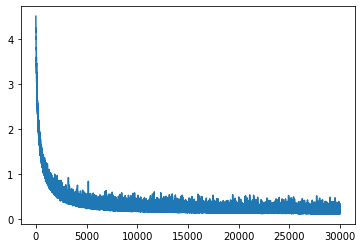

In [18]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, epochs+1):
    (inputs, labels) = create_train_batch(batch_size) # creats train batch
    loss = model.train_on_batch(inputs, labels) # trains model on batch
    losses.append(loss) 
    
    if i % test_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} minutes".format(i,  round((time.time() - t_start)/60.0),2))
        print("Train Loss: {0}".format(loss)) 
        test_acc = test_one_shot(model, N_way, n_test) # tests model using N_way one shot

        if test_acc >= best:
            print("Current best: {0}, previous best: {1}".format(test_acc, best))
            best = test_acc
            best_model = get_siamese_model()
            best_model.set_weights(model.get_weights())
    gc.collect() # to avoid memory error

# visualise train losses over the number of epochs   
plt.plot(losses)
plt.show()

Lets see the best accuracy the model got.

In [22]:
print(f'Best Accuracy gotten is: {best}%')

Best Accuracy gotten is: 87.2%


### Baseline model for comparison

K_nearest Neighbours is used as the baseline model. We need to calculate the minimum distance between the test image and the reference images, but, the images are not in the form of vectors, instead, they are in the form of gray scale images (matrices), therefore, we first flatten the matrices and then calculate the euclidean distance (L2) between each seperate pair of images.

Therefore, in N-way One Shot learning, we compare the L2 distance of the test image with all the images in the Test Set. Then we check the character for which we got the minimum L2 distance. If this character is the same as the character in the test image, then the prediction is correct, else the prediction is incorrect.

Similar to N way one shot learning, we repeat this for multiple trials and compute the average prediction score over all the trials.

In [97]:
def pairwise_dist(imgs0, imgs1):
    """returns the pairwise euclidean distances of each pair of images from imgs0 and imgs1"""
    pw_distances = np.zeros(imgs0.shape[0])
    for i in range(imgs0.shape[0]):
        pw_distances[i] = np.sqrt(np.sum(np.power((imgs0[i] - imgs1[i]), 2))) # euclidean distance
    
    return pw_distances

def test_nearest_neighbors(N,k):
    """Returns average N way one shot learning accuracy of nearest neigbors over k trails"""
    
    print("Evaluating nearest neighbour on {} random {} way one-shot learning tasks ...".format(k,N))

    n_correct = 0 # number of correctly predicted samples
    
    for i in range(k):
        inputs = create_test_batch(N) # create test batch
        outputs = pairwise_dist(inputs[0], inputs[1]) #compute pairwise euclidean distance on test batch
        
        # only the first 2 pairs of images are from the same character so the highest simlarity should be at position 0
        if(np.argmin(outputs) == 0): 
            n_correct += 1
        
    # get the percentage of correct predictions
    pc_correct = (100.0 * n_correct / k)
        
    print("\nGot an average of {}% for nearest neighbor {} way one-shot learning accuracy \n".format(pc_correct,N))
    
    return pc_correct

Define the batch and testing functions for testing the training set on the trained model

In [104]:
def create_train_test_batch(N):
    """Creates pairs of test image, test set for testing N way one-shot learning (from training set). """

    chars, examples, w, h = test.shape
    
    # randomly sample several alphabets to use in batch
    alphas = np.random.choice(list(alpha_train.keys()), size = 10, replace = False)
    
    # get the postions of the characters for each alphabet then stack them into a single list 
    n_char = ([np.arange(alpha_train[alpha][0],alpha_train[alpha][1]) for alpha in alphas])

    n_chars = []
    for l in n_char:
        n_chars.extend(l)
        
    # randomly sample N characters from the randomly generated ones to use for testing 
    characters = np.random.choice(n_chars,size = N,replace=False)
    
    test_char = characters[0] # to use a the test character
    
    # randomly sample 2 examples from the images of the character 
    example1, example2 = np.random.choice(examples,replace=False,size = 2)
    # concat example1 N times to use for test comparision
    test_image = np.asarray([train[test_char,example1,:,:]]*N).reshape(N, w, h,1)
    # randomly sample N examples to use from other characters for test comparision 
    ex_indices = np.random.randint(0, examples,size=(N,))
    
    test_set = train[characters,ex_indices,:,:]
    # set the first image in the test_set to example2
    test_set[0,:,:] = train[test_char,example2]
    test_set = test_set.reshape(N, w, h,1)
    # concat test_image and test_set pairs
    pairs = [test_image,test_set]

    return pairs

def test_train_one_shot(model, N, k):
    """Test average N way one shot learning accuracy of a siamese neural net model over k one shot tasks (from train set)"""
    correct = 00
    
    print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    
    for i in range(k):
        inputs = create_train_test_batch(N) # create train test batch
        simlarity = model.predict(inputs) # predict output on batch
        
        # only the first 2 pairs of images are from the same character so the highest simlarity should be at position 0
        if np.argmax(simlarity) == 0:
            correct+=1
    
    # get the percentage of correct predictions
    pc_correct = (100.0 * correct / k)
    
    print("Got an average of {}% for {} way one-shot learning accuracy \n".format(pc_correct,N))
    
    return pc_correct

Test the best trained model (that performed best on the test set) on the train set, test set and  using k nearest neigbors  

In [105]:
n_ways = np.arange(1, 21, 1) # array of different class sizes for testing one-shot tasks
train_accuracy, test_accuracy, nn_accuracy = [], [], [] # accuracies of train, test and nearest neghbours 
k = 500 # number of trials
for N in n_ways:
    train_accuracy.append(test_train_one_shot(best_model, N, k))
    test_accuracy.append(test_one_shot(best_model, N, k))
    nn_accuracy.append(test_nearest_neighbors(N, k))

Evaluating model on 500 random 1 way one-shot learning tasks ... 

Got an average of 100.0% for 1 way one-shot learning accuracy 

Evaluating model on 500 random 1 way one-shot learning tasks ... 

Got an average of 100.0% for 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 500 random 1 way one-shot learning tasks ...

Got an average of 100.0% for nearest neighbor 1 way one-shot learning accuracy 

Evaluating model on 500 random 2 way one-shot learning tasks ... 

Got an average of 99.6% for 2 way one-shot learning accuracy 

Evaluating model on 500 random 2 way one-shot learning tasks ... 

Got an average of 98.4% for 2 way one-shot learning accuracy 

Evaluating nearest neighbour on 500 random 2 way one-shot learning tasks ...

Got an average of 64.8% for nearest neighbor 2 way one-shot learning accuracy 

Evaluating model on 500 random 3 way one-shot learning tasks ... 

Got an average of 99.0% for 3 way one-shot learning accuracy 

Evaluating model on 500 random 

Got an average of 84.4% for 20 way one-shot learning accuracy 

Evaluating nearest neighbour on 500 random 20 way one-shot learning tasks ...

Got an average of 18.0% for nearest neighbor 20 way one-shot learning accuracy 



Visualise the performance of the model on the train, test, nearest neighbor and random guessing

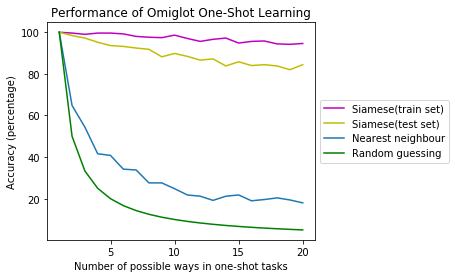

In [107]:
fig,ax = plt.subplots(1)
ax.plot(n_ways, train_accuracy, "m", label="Siamese(train set)")
ax.plot(n_ways, test_accuracy, "y", label="Siamese(test set)")
plt.plot(n_ways, nn_accuracy, label="Nearest neighbour")

ax.plot(n_ways, 100.0/n_ways, "g", label="Random guessing")
plt.xlabel("Number of possible ways in one-shot tasks")
plt.ylabel("Accuracy (percentage)")
plt.title("Performance of Omiglot One-Shot Learning")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Visiualizing a test image and a test set batch used in testing the model

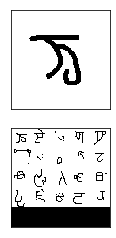

In [109]:
def concat_images(imgs):
    """Concatenates a bunch of images into a big image for plotting."""
    chars, height , width, _ = imgs.shape
    imgs = imgs.reshape(chars, height, width)
    n = np.ceil(np.sqrt(chars)).astype("int8")
    img = np.zeros((n*width,n*height)) # image output
    x = 0
    y = 0
    for image in range(chars):
        img[y*width:(y+1)*width,x*height:(x+1)*height] = imgs[image]
        x += 1
        if x == n:
            x = 0
            y += 1
    return img


def plot_oneshot_images(pairs):
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

pairs = create_test_batch(20)
plot_oneshot_images(pairs)

## Conclusion 

The best accuracy gotten by the above model was 87.2%. The model did perform better the k nearest neighbor and random guessing. However, the performance on the test set was lower than the train set which is possibly due to the model overfitting a bit. One of the main reasons for this can be that the learing decay for each layer (as mentioned in the original paper), has not been implemented in this notebook. 

Moreover, the number of iterations might make a difference in the results. Currently the model has been trained for 30,000 iterations with one iteration being one full pass over a batch form the train set.

I think the following might also improve the model results:

1. Using Bayesian optimization to find a better set of hyperparameters
2. Using a learning rate finder to find a better value.
3. Using some image transformations (e.g. resize, rotate, scale, etc.) which might reduce overfitting 
4. Selecting a better validation set. A more accurate validation set can be that instead of choosing whole alphabets first, we could choose various characters from all the alphabets to keep in the validation set.
5. Ensembling several models to reduce overfitting.

To warp up, image verification is the task you're given two images and you have to tell if they are of the same class or category. In context of the problem we have in hand, classifying similar images of characters as the same is the main problem we need to solve. Therefore, choosing accuracy as the metric is what we should use to validate the performance of our model on new unseen data.